<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


In [44]:
#to make life easier
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [46]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD

In [47]:
import src.maths.func_stats as fstats

# Load the data

In [48]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

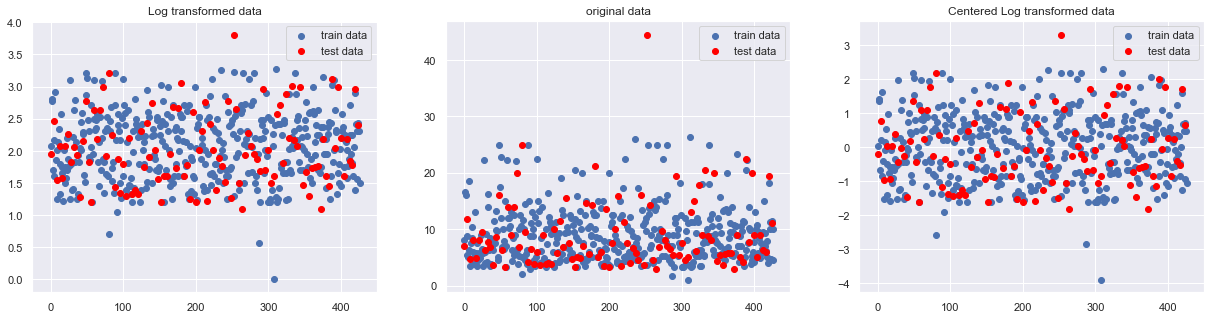

In [49]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

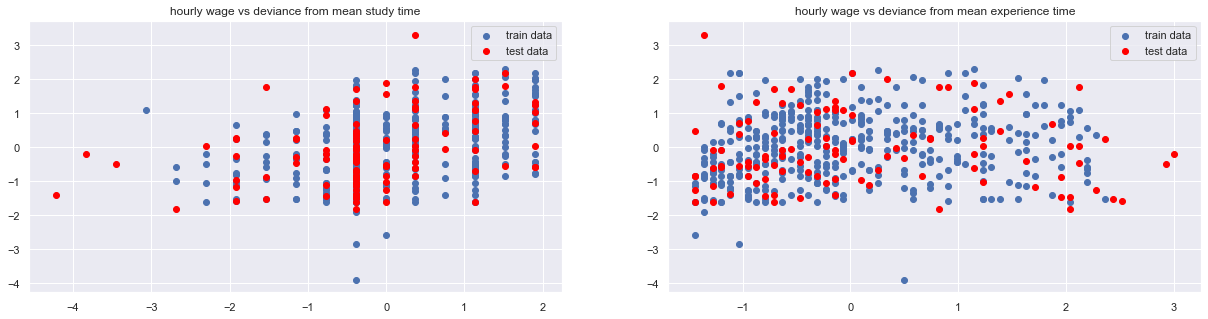

In [50]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [51]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

## Obtaining estimates of the parameters

## using MAP

#### using vanilla gradient descent

In [52]:
GD.vanilla_gd(model_gaussian, max_iter= 8000)
GD.vanilla_gd(model_student, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:15
Progress : [====================] 100% Done...
   duration: 0:00:20


#### using line search

In [53]:
GD.line_search_gd(model_gaussian, lambda_ = 1e-3,x0 = np.ones(model_gaussian.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 797  duration: 0:00:02


In [54]:
GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 8000)

Progress : [====================] 100% Done...
   duration: 0:00:30


#### using Wolfe condition to adpat the step size

In [55]:
GD.Wolfe_cond_gd(model_gaussian, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size))

Progress : [                    ] 0.53%  

[autoreload of src.models.Model failed: Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/charles/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/charles/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/charles/

Progress : [====================] 100% Done...
   duration: 0:00:31


In [56]:
GD.Wolfe_cond_gd(model_student, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_student.size))

Progress : [====================] 100% Done...
   duration: 0:00:40


## Using Metropolis Hastings

#### with gaussian random walk

Progress : [                    ] 1.46%  

[autoreload of src.models.Model failed: Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/charles/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/charles/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/charles/

Progress : [====================] 100% Done...
  Acceptance rate : 16.2%  (advised values between 10% and 50%)
  duration: 0:00:12
iterations


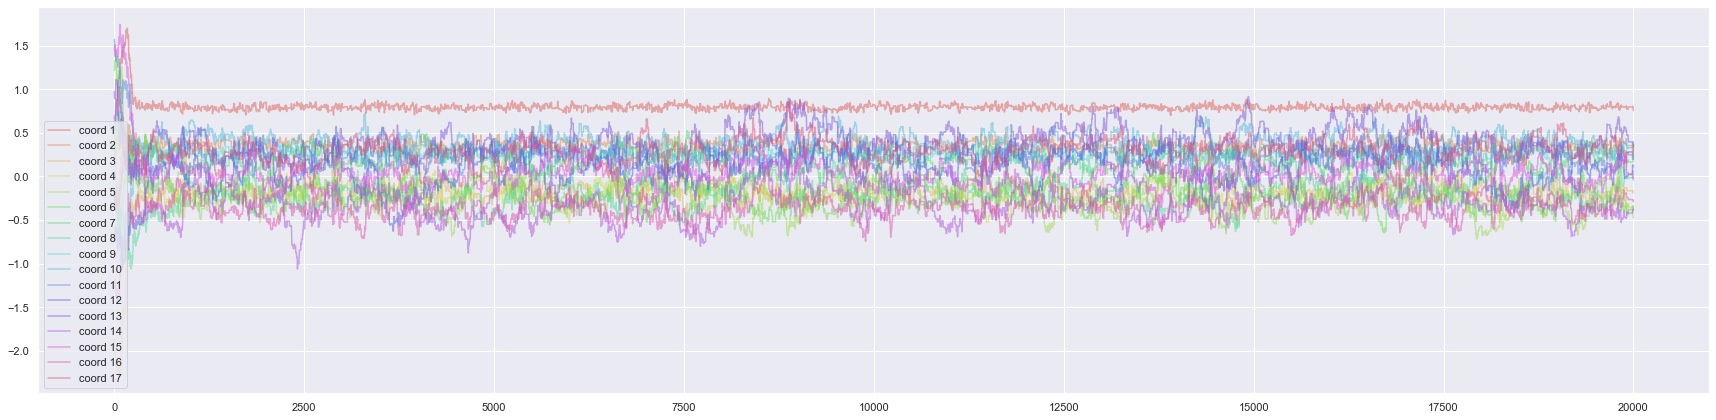

In [57]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 39.1%  (advised values between 10% and 50%)
  duration: 0:00:15
iterations


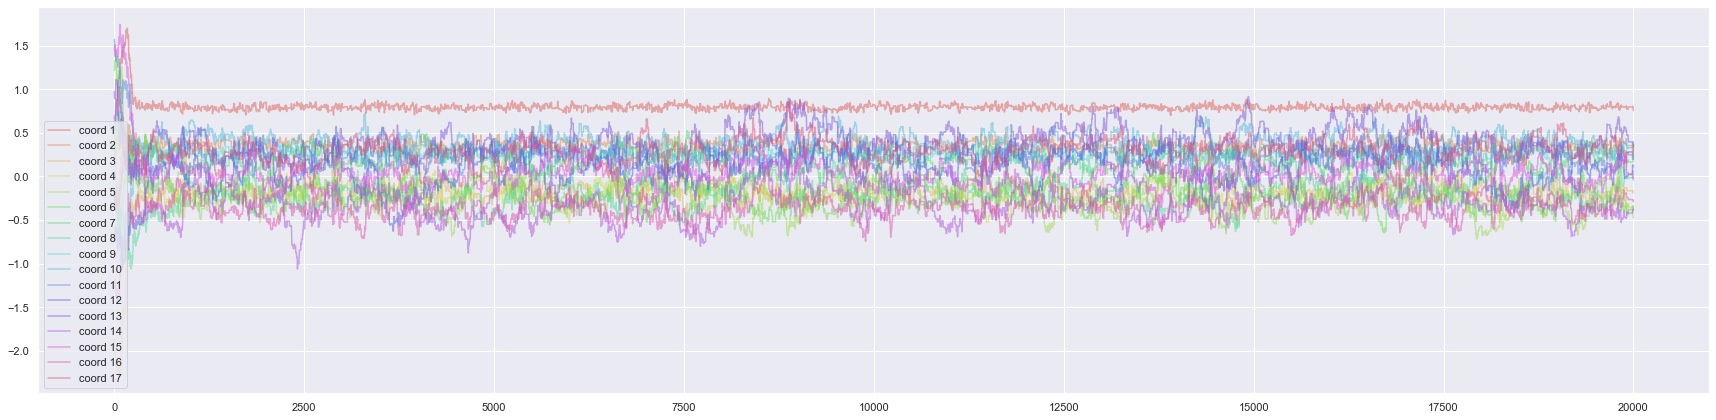

In [58]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 59.6%                 (advised values between 10% and 50%)
  duration: 0:01:36
iterations


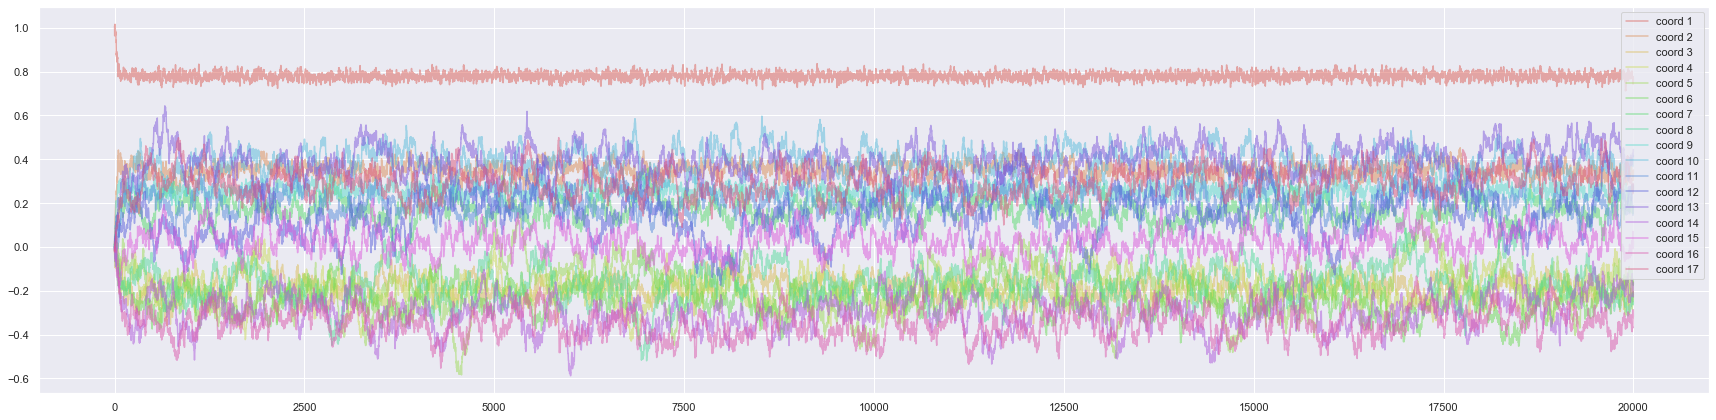

In [59]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 26.0%                 (advised values between 10% and 50%)
  duration: 0:02:15
iterations


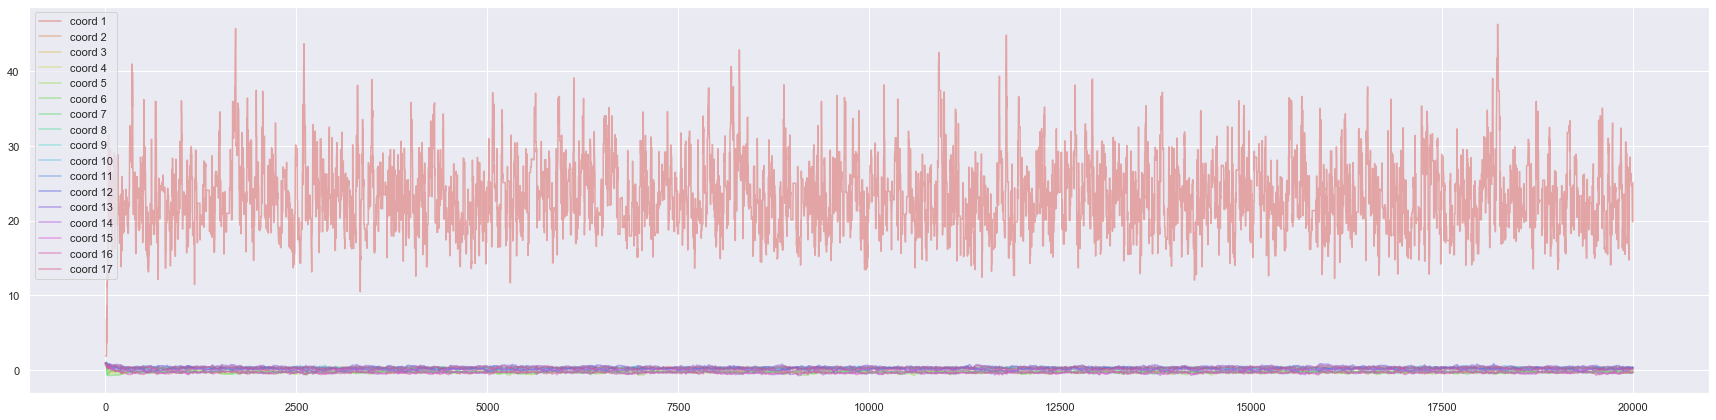

In [60]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### comparison of the metropolis hastings chains

gaussian model

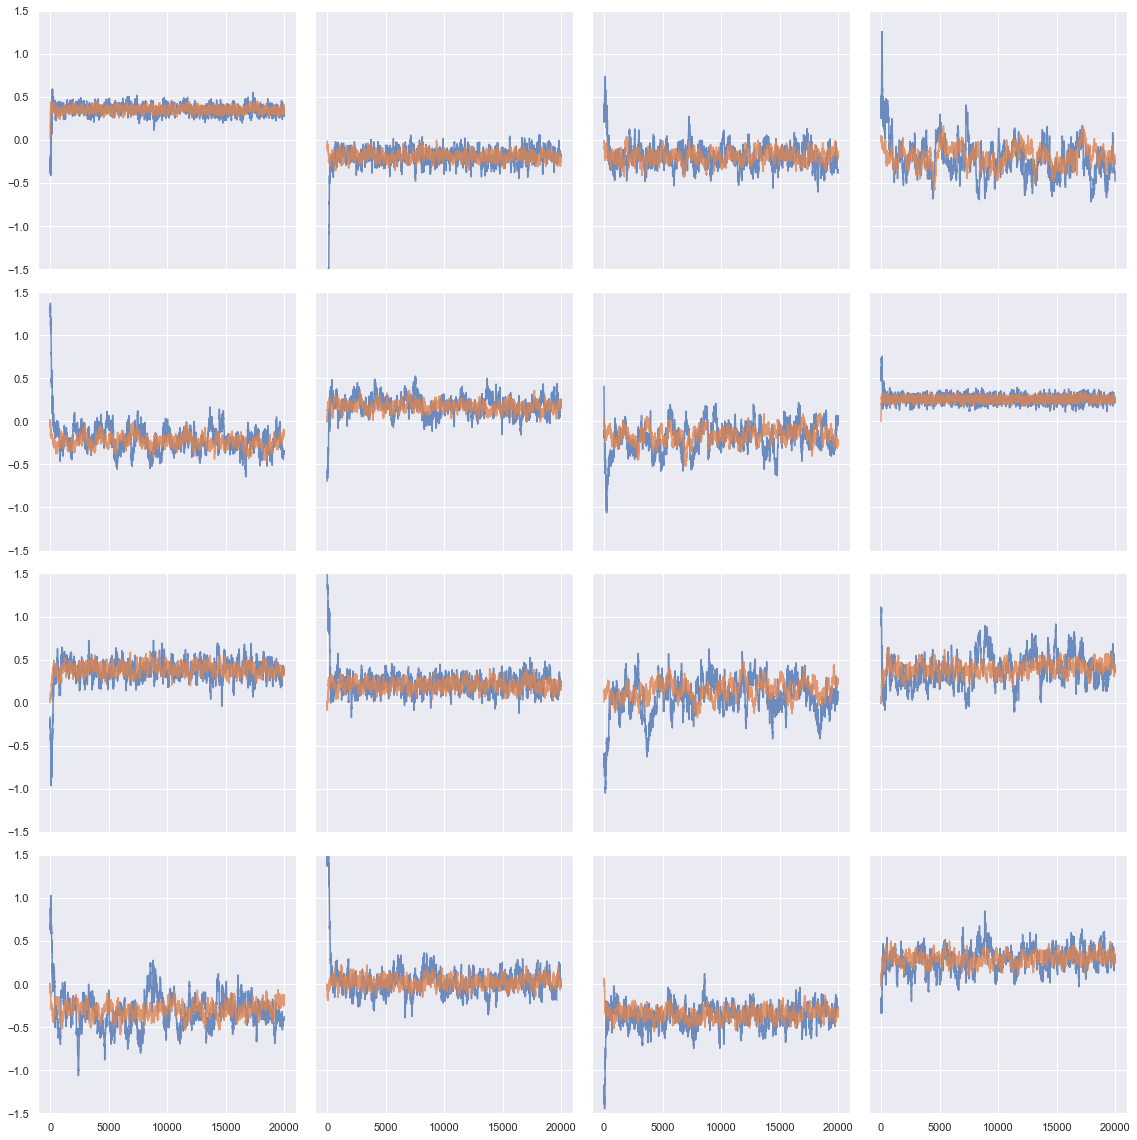

In [61]:
compare_samples_MH(samples_gaussian_rw,samples_gaussian_langevin)

student model

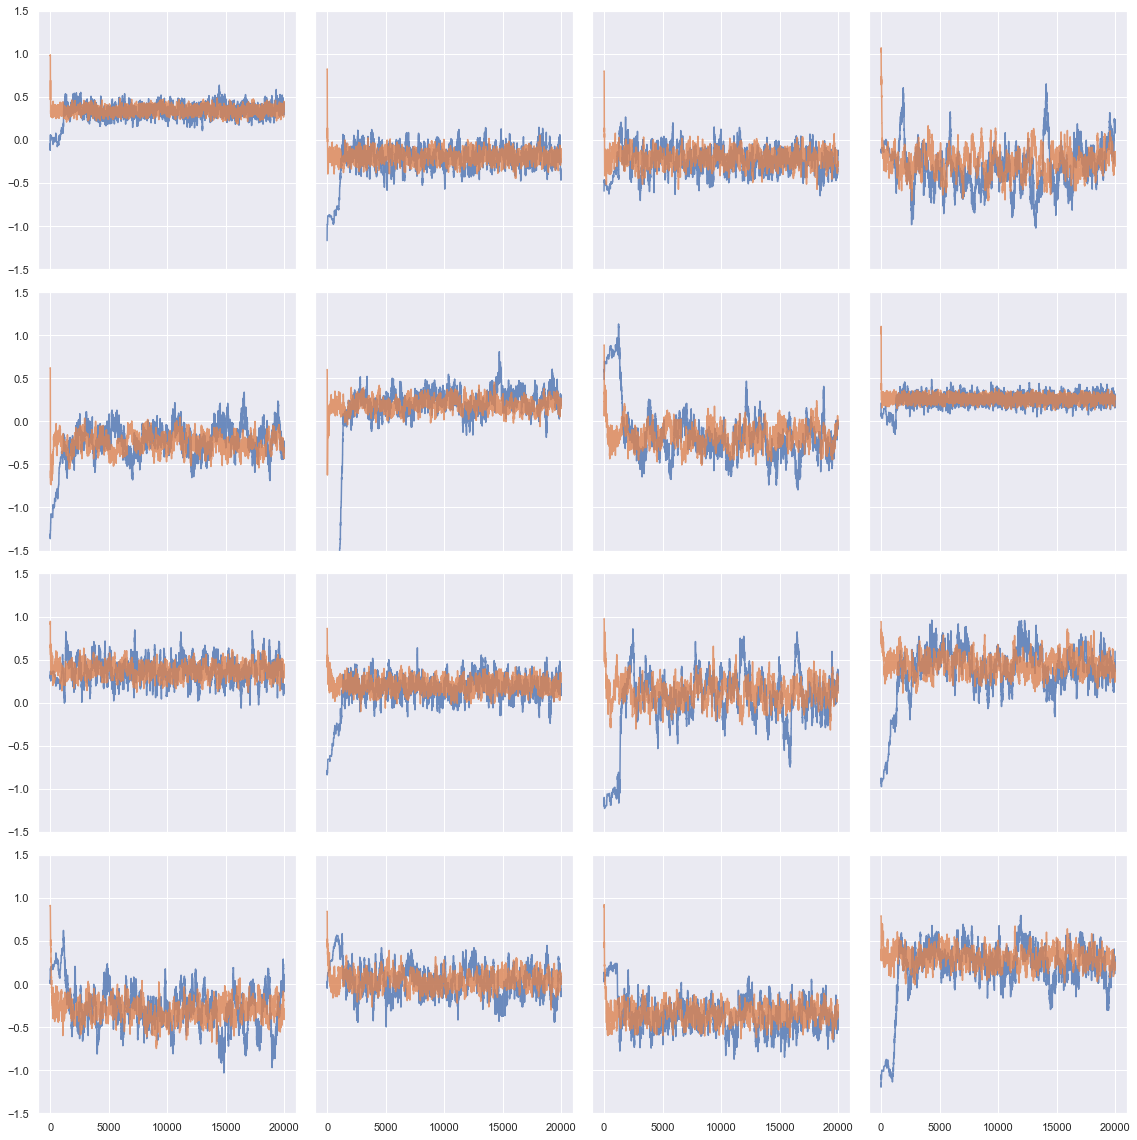

In [62]:
compare_samples_MH(samples_student_rw,samples_student_langevin)

### extraction of the estimates from the models

In [63]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH      HISP  \
gd                  0.773617  0.351708 -0.185607 -0.204572 -0.212705   
line_search_gd      0.773617  0.351707 -0.185607 -0.204573 -0.212708   
Wolfe_cond_gd       0.937500  0.467542  0.014844  0.226920  0.410712   
MH_vanilla_mean     0.791753  0.348040 -0.188771 -0.194276 -0.241706   
MH_vanilla_median   0.791091  0.349530 -0.187726 -0.198981 -0.246363   
MH_Langevin_mean    0.778967  0.351356 -0.189095 -0.192275 -0.190343   
MH_Langevin_median  0.778880  0.350901 -0.189823 -0.189164 -0.186658   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.239064  0.169972 -0.162227  0.258266  0.385553   
line_search_gd     -0.239071  0.169967 -0.162219  0.258266  0.385554   
Wolfe_cond_gd      -0.229593 -0.202774 -0.022500  0.332110  0.352425   
MH_vanilla_mean    -0.217959  0.180809 -0.177939  0.256669  0.382928   
MH_vanilla_median  -0.223728  0.179691 -0.171179  0.258973  0.383026   
MH_Langevin_mean   -0.235408  0.169991 -0.163018  0.257246  0.392079   
MH_Langevin_median -0.235382  0.170090 -0.165390  0.257829  0.391895   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.212761  0.141786  0.393537 -0.297687  0.025750   
line_search_gd      0.212764  0.141789  0.393543 -0.297681  0.025755   
Wolfe_cond_gd       0.328985  0.457122  0.419534  0.369744  0.224076   
MH_vanilla_mean     0.211204  0.094051  0.393569 -0.328597  0.010581   
MH_vanilla_median   0.212539  0.106282  0.386021 -0.334730  0.008935   
MH_Langevin_mean    0.203084  0.151746  0.395856 -0.298511  0.023013   
MH_Langevin_median  0.200517  0.153309  0.398161 -0.295813  0.021441   

                        SERV      PROF  
gd                 -0.345087  0.297527  
line_search_gd     -0.345082  0.297534  
Wolfe_cond_gd       0.208475  0.328472  
MH_vanilla_mean    -0.369195  0.295209  
MH_vanilla_median  -0.360571  0.296693  
MH_Langevin_mean   -0.349809  0.295438  
MH_Langevin_median -0.349614  0.296392

In [64]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH      HISP  \
gd                   6.707993  0.339444 -0.204353 -0.240637 -0.297164   
line_search_gd      18.744119  0.341741 -0.197535 -0.220067 -0.256264   
Wolfe_cond_gd        6.339830  0.339387 -0.204712 -0.242420 -0.299998   
MH_vanilla_mean     24.142726  0.343364 -0.190020 -0.236009 -0.351220   
MH_vanilla_median   23.224421  0.340509 -0.192547 -0.234703 -0.355002   
MH_Langevin_mean    23.263800  0.342917 -0.193353 -0.213965 -0.260811   
MH_Langevin_median  22.741907  0.342397 -0.192327 -0.209433 -0.259404   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.265349  0.207053 -0.187735  0.264386  0.365822   
line_search_gd     -0.251051  0.190463 -0.178088  0.260819  0.373601   
Wolfe_cond_gd      -0.267034  0.207635 -0.187642  0.264635  0.365522   
MH_vanilla_mean    -0.198638  0.231757 -0.229998  0.256516  0.370094   
MH_vanilla_median  -0.194302  0.231208 -0.233563  0.255886  0.369857   
MH_Langevin_mean   -0.250209  0.195247 -0.179284  0.259467  0.371657   
MH_Langevin_median -0.248741  0.197683 -0.186268  0.259719  0.371258   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.205245  0.122554  0.503637 -0.280381  0.059651   
line_search_gd      0.206468  0.129351  0.461792 -0.290331  0.042638   
Wolfe_cond_gd       0.205477  0.122620  0.506597 -0.278924  0.061327   
MH_vanilla_mean     0.178633  0.100499  0.434997 -0.310931  0.013256   
MH_vanilla_median   0.178195  0.098167  0.435553 -0.298156  0.016976   
MH_Langevin_mean    0.203567  0.111527  0.440220 -0.307614  0.040123   
MH_Langevin_median  0.204731  0.110927  0.438146 -0.308225  0.039254   

                        SERV      PROF  
gd                 -0.359395  0.313160  
line_search_gd     -0.351271  0.308540  
Wolfe_cond_gd      -0.359544  0.313935  
MH_vanilla_mean    -0.390545  0.261860  
MH_vanilla_median  -0.392562  0.268227  
MH_Langevin_mean   -0.349304  0.305707  
MH_Langevin_median -0.350962  0.304223

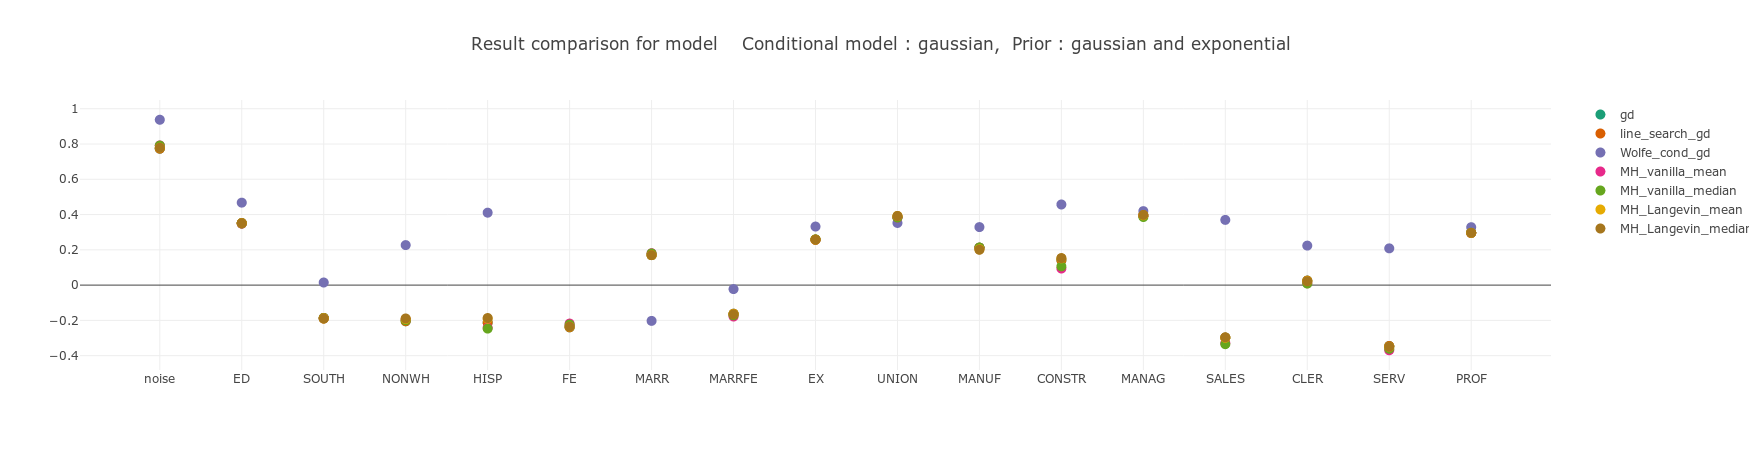

In [65]:
visualisation(r_gaussian,model_gaussian)

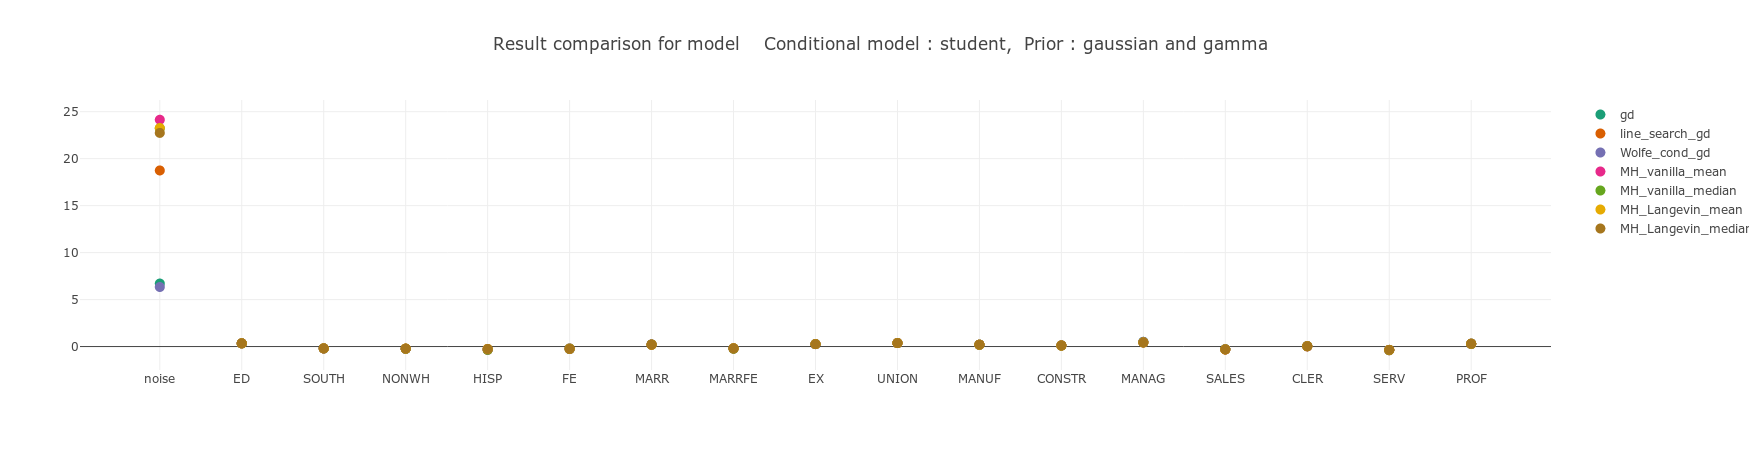

In [66]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In order to predict, we have to use : $$ f(y| D = d) = \int f(y,\theta|D = d)d\theta = \int f(y|\theta)f(\theta|D=d)d\theta$$
Since we suppose our data are iid, the dependence of $y$ to $D$ is only through $\theta$



Supposing we want to approximate $y$ by its mean in the case of our first model, with the gaussian noise, gaussian prior on $\beta$ and exponential prior on $\sigma$:

\begin{align} \mathbb{E}[y|D=d] &= \int y f(y|D=d)dy \\
&= \int y \int f(y|\theta)f(\theta|D=d)d\theta dy \\
&= \int\int y f(y|\theta)f(\theta|D=d)d\theta dy\\
&= \int\left( \int y f(y|\theta)dy \right) f(\theta|D=d)d\theta \\
&= \int x^T\beta f(\theta|D=d)d\theta \\ 
&= \mathbb{E}_{\theta \sim \theta|D=d}[x^T\beta]\\
&= x^T \widehat{\beta}
\end{align}

So supposing we can switch the integrals (using Fubini since both functions are positive (densities) and the integral $\int y f(y|\theta)f(\theta|D=d)d\theta dy $ is finite ), the point prediction can be done by either marginalizing out the $\theta$, or by first finding the "optimal" theta and then predicting the MAP of the conditional model. This is logic given that the marginalization of the $\theta$ is there because we do not know the distribution of the $\theta$, but only its distribution. But if we are interested in a point estimate, this inflation in the uncertainty of our precision is not directly usefull.


For our second model, the same development holds.

We will compare the two methods and still use Metropolis Hastings with random walk to compute prediction in a truly bayesian way, which gives us the possibility if we wanted to compute credible intervals 

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [67]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
gd                       0.685706        0.613765
line_search_gd           0.685706        0.613765
Wolfe_cond_gd            0.738525        0.692682
MH_vanilla_mean          0.687220        0.613360
MH_vanilla_median        0.686844        0.613644
MH_Langevin_mean         0.685343        0.613941
MH_Langevin_median       0.684926        0.613918

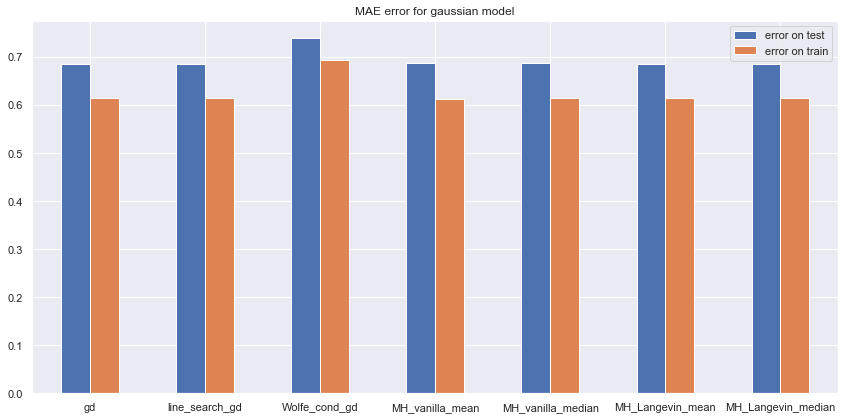

In [68]:
big_plot(12,6)
errors_gaussian.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for gaussian model")
plt.tight_layout()
reset_plot()

In [69]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
gd                       0.685278        0.609904
line_search_gd           0.685159        0.611209
Wolfe_cond_gd            0.685284        0.609814
MH_vanilla_mean          0.692063        0.610830
MH_vanilla_median        0.692378        0.610754
MH_Langevin_mean         0.684329        0.612063
MH_Langevin_median       0.683907        0.612103

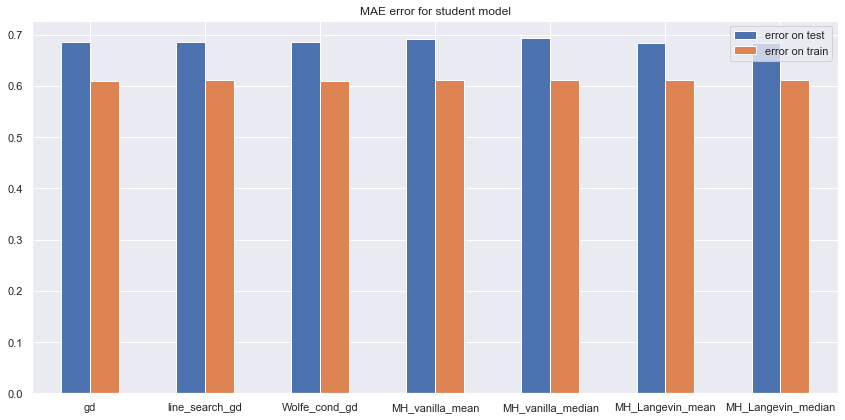

In [70]:
big_plot(12,6)
errors_student.T.plot.bar()
plt.xticks(rotation="horizontal")
plt.title("MAE error for student model")
plt.tight_layout()
reset_plot()

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

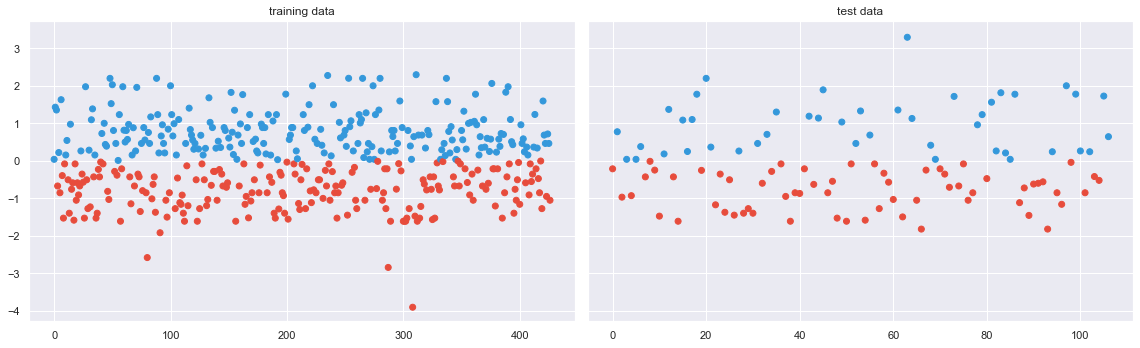

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

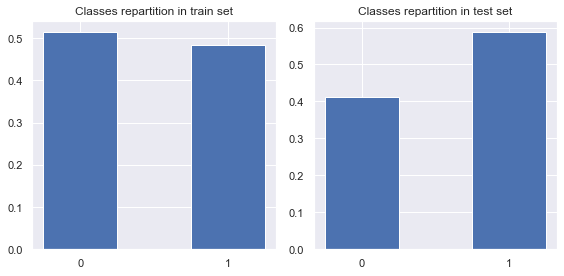

In [72]:
plt.subplot(121)
plt.bar([0.4,0.8],[len(classes[classes==0])/len(classes),len(classes[classes==1])/len(classes)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in train set")
plt.subplot(122)
plt.bar([0.4,0.8],[len(classes_test[classes_test==0])/len(classes_test),len(classes_test[classes_test==1])/len(classes_test)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in test set")
plt.tight_layout()
plt.show()

In [73]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X,response = classes, Prior = [0,3*np.ones(16)],cond_model = [2])

In [74]:
GD.vanilla_gd(multilogi, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:08


In [75]:
GD.line_search_gd(multilogi, lambda_ = 1e-3,x0 = np.ones(multilogi.size),max_iter = 8000)

Progress : [                    ] 1.95%  

[autoreload of src.models.Model failed: Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/charles/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/charles/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/charles/

Progress : [====================] 100% Done...
 converged early at iteration 5606  duration: 0:00:07


In [76]:
GD.Wolfe_cond_gd(multilogi, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(multilogi.size))

Progress : [====================] 100% Done...
   duration: 0:00:10


Progress : [                    ] 0.97%  

[autoreload of src.models.Model failed: Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/charles/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/charles/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/charles/

Progress : [====================] 100% Done...
  Acceptance rate : 38.2%  (advised values between 10% and 50%)
  duration: 0:00:21
iterations


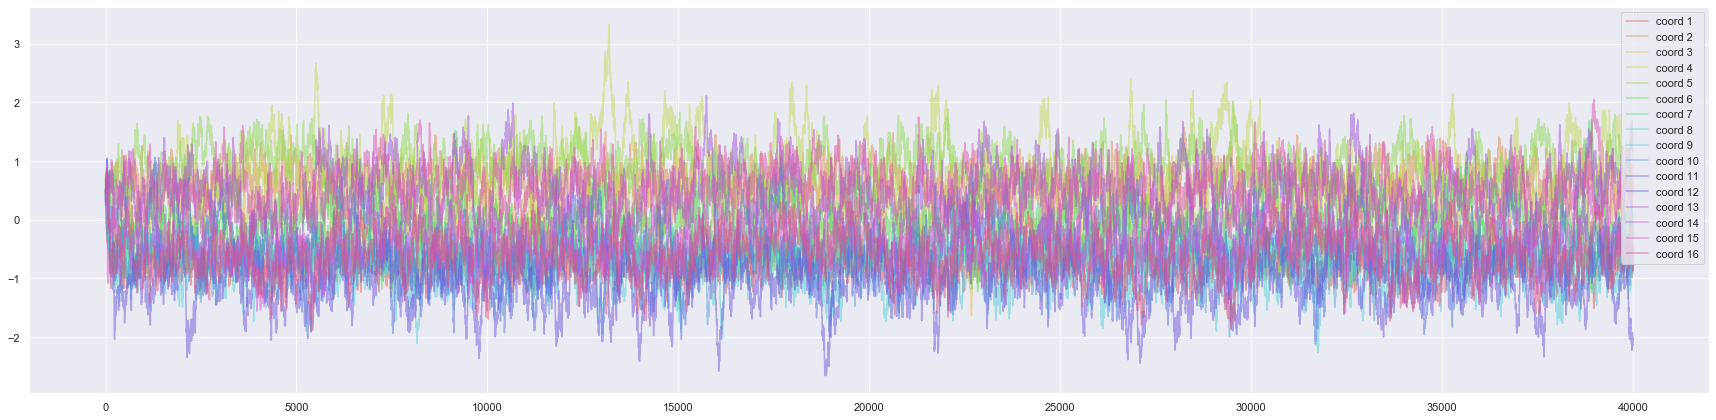

In [77]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [                    ] 0.24%  

[autoreload of src.models.Model failed: Traceback (most recent call last):
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/charles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/home/charles/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/charles/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/charles/

Progress : [====================] 100% Done...
  Acceptance rate : 18.0%                 (advised values between 10% and 50%)
  duration: 0:01:19
iterations


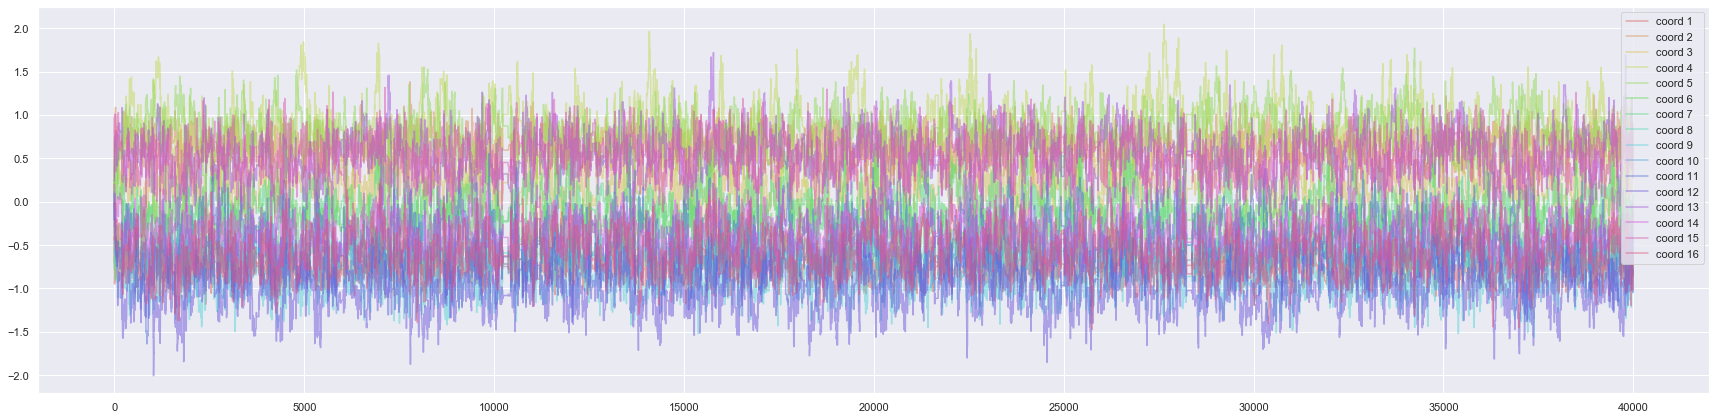

In [78]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

In [79]:
r_multilogi = multilogi()
r_multilogi.T

ED     SOUTH     NONWH      HISP        FE  \
gd                 -0.743577  0.648029  0.184270  0.656163  0.704379   
line_search_gd     -0.745740  0.637126  0.198143  0.750089  0.749299   
Wolfe_cond_gd      -0.745817  0.637126  0.198003  0.749741  0.748650   
MH_vanilla_mean    -0.772895  0.705886  0.208495  0.753112  0.823960   
MH_vanilla_median  -0.771038  0.702152  0.206999  0.725717  0.828402   
MH_Langevin_mean   -0.757375  0.650147  0.193796  0.765719  0.773036   
MH_Langevin_median -0.753999  0.651862  0.197762  0.754297  0.760708   

                        MARR    MARRFE        EX     UNION     MANUF  \
gd                 -0.297839 -0.033348 -0.567194 -0.863941 -0.627922   
line_search_gd     -0.276186 -0.094773 -0.566730 -0.871967 -0.642510   
Wolfe_cond_gd      -0.276601 -0.094112 -0.566733 -0.871869 -0.642297   
MH_vanilla_mean    -0.283971 -0.117411 -0.586452 -0.915854 -0.700761   
MH_vanilla_median  -0.276049 -0.120313 -0.584014 -0.911334 -0.695606   
MH_Langevin_mean   -0.275768 -0.107791 -0.578516 -0.889094 -0.654122   
MH_Langevin_median -0.280021 -0.094308 -0.578990 -0.889239 -0.651868   

                      CONSTR     MANAG     SALES      CLER      SERV      PROF  
gd                 -0.448299 -0.948350  0.490777 -0.328606  0.542705 -0.544935  
line_search_gd     -0.481143 -0.962650  0.510775 -0.344109  0.521019 -0.564106  
Wolfe_cond_gd      -0.480883 -0.962098  0.511308 -0.343662  0.521453 -0.563554  
MH_vanilla_mean    -0.467169 -1.058410  0.485538 -0.407329  0.529978 -0.613939  
MH_vanilla_median  -0.463966 -1.046221  0.486395 -0.408595  0.522430 -0.599505  
MH_Langevin_mean   -0.477473 -0.991910  0.524803 -0.356121  0.537491 -0.583155  
MH_Langevin_median -0.472582 -0.995822  0.516986 -0.358957  0.535277 -0.584081

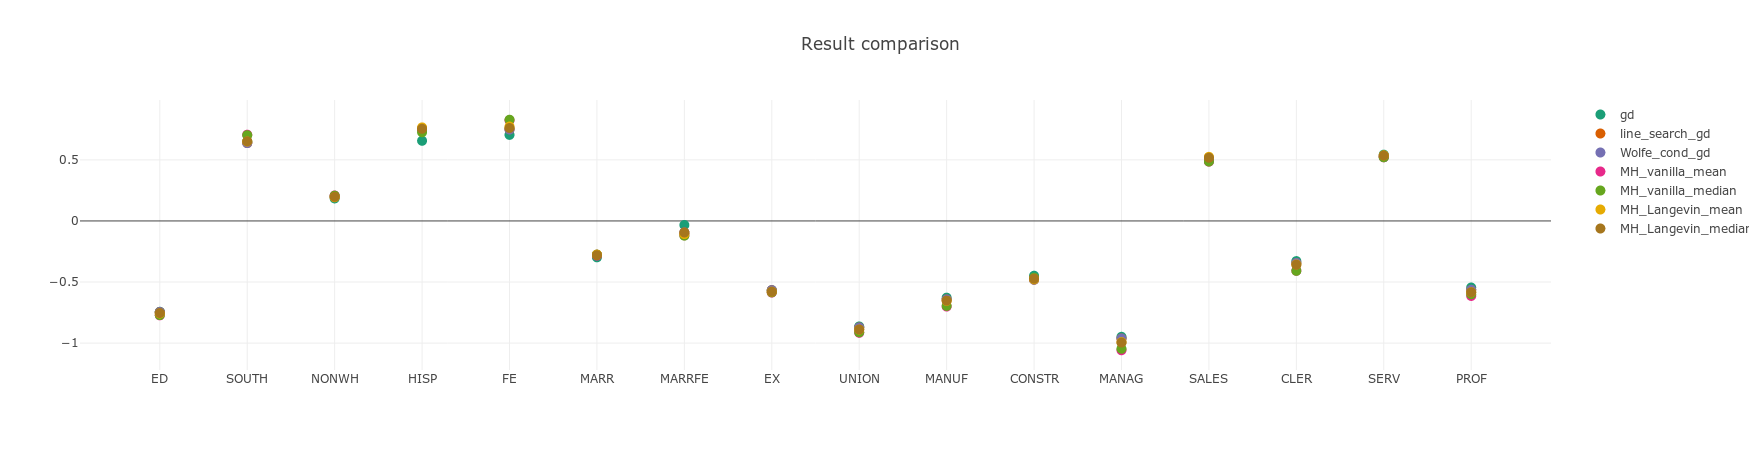

In [80]:
visualisation(r_multilogi,multilogi)

## Results of logistic regression

In order to predict, we will minimize the misclassification error, which mean we will use the decision boundary $\mathbb{P}[Y=1|x]>=0.5$.

Following Bishop _Pattern recognition and Machine learning_, p.220, we first compute the MAP of our parameter $\beta$, and then use it to predict our classes using the decisin boundary above.

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [81]:
predictions = multilogi.predict(X_test)
fitted = multilogi.predict(X)

In [82]:
errors = {}

In [83]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [84]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [85]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
gd                       0.467290        0.271663
line_search_gd           0.467290        0.269321
Wolfe_cond_gd            0.467290        0.269321
MH_vanilla_mean          0.476636        0.271663
MH_vanilla_median        0.476636        0.271663
MH_Langevin_mean         0.467290        0.269321
MH_Langevin_median       0.467290        0.269321

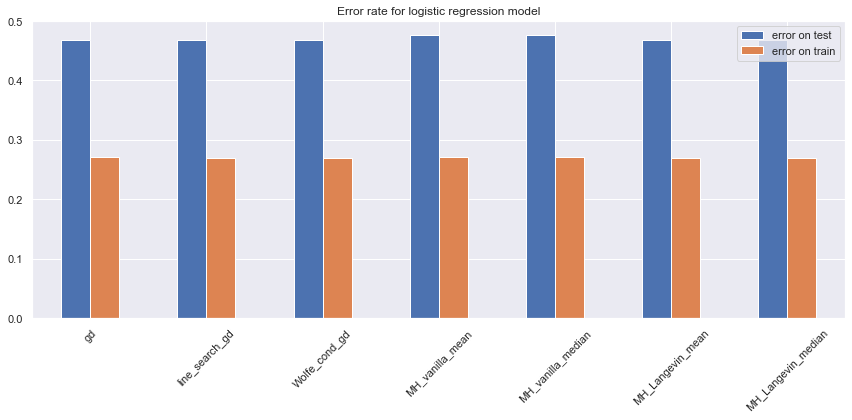

In [86]:
big_plot(12,6)
errors.T.plot.bar()
plt.xticks(rotation=45)
plt.title("Error rate for logistic regression model")
plt.tight_layout()
reset_plot()